<a href="https://colab.research.google.com/github/amarsinghen/imdb-reviews--sentiment-analysis/blob/main/imdb_movie_reviews_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
!nvidia-smi

Fri Oct  2 04:46:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install contractions

     |████████████████████████████████| 245kB 10.2MB/s 
     |████████████████████████████████| 317kB 14.8MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81703 sha256=9a2fe618e979b23c1d6b7535adc354a8025cb00468e02e99c7cf23595720864f
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [4]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import gc
import re
import os
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
import unicodedata
import spacy
from bs4 import BeautifulSoup
import unicodedata
import contractions
import pickle
import gzip
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import seaborn as sns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, Conv1D, GlobalMaxPool1D, Dropout, concatenate, Layer, InputSpec, LSTM
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import MaxNorm

## Loading raw data from kaggle

In [6]:
# Downloading the data from kaggle for first time, and 
# then saving to google drive for future uses. It is faster this way
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/kaggle.json' ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 35% 9.00M/25.7M [00:00<00:01, 12.3MB/s]
100% 25.7M/25.7M [00:00<00:00, 27.9MB/s]


In [7]:
import zipfile
local_zip = ['imdb-dataset-of-50k-movie-reviews.zip']
for i in range(len(local_zip)):
    zip_ref = zipfile.ZipFile(local_zip[i], 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()

### Creating pandas dataframe

In [8]:
train_df = pd.read_csv('/tmp/IMDB Dataset.csv')
train_df[:2]

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


In [9]:
train_df["reviews_char_length"] = train_df['review'].str.len()
print(train_df[:2])

                                              review  ... reviews_char_length
0  One of the other reviewers has mentioned that ...  ...                1761
1  A wonderful little production. <br /><br />The...  ...                 998

[2 rows x 3 columns]


In [10]:
train_df['review'].loc[:0].str.split()

0    [One, of, the, other, reviewers, has, mentione...
Name: review, dtype: object

In [11]:
train_df["reviews_words_counts"] = train_df['review'].str.split().str.len()
print(train_df[:2])

                                              review  ... reviews_words_counts
0  One of the other reviewers has mentioned that ...  ...                  307
1  A wonderful little production. <br /><br />The...  ...                  162

[2 rows x 4 columns]


In [12]:
train_df.describe()

,reviews_char_length,reviews_words_counts
count,50000.000000,50000.000000
mean,1309.431020,231.156940
std,989.728014,171.343997
min,32.000000,4.000000
25%,699.000000,126.000000
50%,970.000000,173.000000
75%,1590.250000,280.000000
max,13704.000000,2470.000000


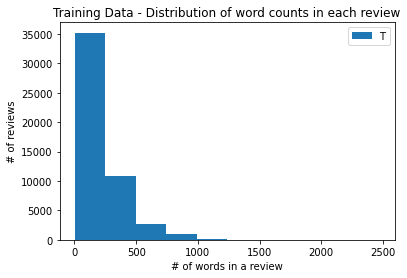

In [13]:
plt.hist(train_df["reviews_words_counts"])
plt.title("Training Data - Distribution of word counts in each review")
plt.xlabel("# of words in a review")
plt.ylabel("# of reviews")
plt.legend("Train")

In [14]:
print("Training Data: Review with Max words - {}, Review with Min words - {}, Average # of words - {}".format(train_df["reviews_words_counts"].max(), 
                                                                                                                train_df["reviews_words_counts"].min(), 
                                                                                                                train_df["reviews_words_counts"].mean()))

Training Data: Review with Max words - 2470, Review with Min words - 4, Average # of words - 231.15694


In [15]:
max_count = 1000
print("Check training data for number of reviews with >{} words: {}".format(max_count,train_df.loc[train_df["reviews_words_counts"]>max_count,"reviews_words_counts"].count()))

Check training data for number of reviews with >1000 words: 82


In [16]:
# Checking training Quantile numbers
train_df.reviews_words_counts.quantile([0.01,0.25,0.50,0.75, 0.99])

0.01     42.0
0.25    126.0
0.50    173.0
0.75    280.0
0.99    908.0
Name: reviews_words_counts, dtype: float64

Text(0, 0.5, '# of reviews')

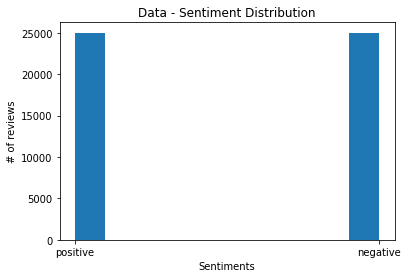

In [17]:
plt.hist(train_df['sentiment'])
plt.title("Data - Sentiment Distribution")
plt.xlabel("Sentiments")
plt.ylabel("# of reviews")

## Read the data from dataframe into sentences list for ease of processing

In [18]:
# Convert from data frame to list of sentences in lower case
train_file_lines = [x.lower() for x in train_df['review']]

In [19]:
print(len(train_file_lines))
print(train_file_lines[:2])

50000
["one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. they are right, as this is exactly what happened with me.<br /><br />the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word.<br /><br />it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />i would say the main appeal of the show is due to

In [20]:
type(train_file_lines)

list

## Create Y-labels for both Train and Test

In [21]:
train_labels = [0 if sentiment == 'negative' else 1 for sentiment in train_df['sentiment']]
print(train_labels[:5])

[1, 1, 1, 0, 1]


## Text Data Pre-Processing

### Replacing urls with the keyword \"url\"

In [22]:
def replace_urls(line):
    if 'www.' in line or 'http:' in line or 'https:' in line or '.com' in line:
       line = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "url", line)
    return line

In [23]:
test_line = 'asjhdgsajhdghttphttps://www.kaggle.com/anshulra'
print(replace_urls(test_line))

url/anshulra


### Removing Html tags

In [24]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

print(strip_html_tags('<html><h2>Some important text</h2></html>'))

Some important text


### Expanding Contractions

In [25]:
def expand_contractions(text):
    try:
        return contractions.fix(text)
    except:
        print(text)
        pass
print(expand_contractions("Y'all can't expand contractions I'd think"))

you all can not expand contractions I would think


### Remove Accented characters

In [26]:
def remove_accented_chars(text):
    try:
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return text
    except:
        print(text)
        pass

print(remove_accented_chars('Sómě Áccěntěd těxt'))

Some Accented text


### Removing Special Characters

In [27]:
def remove_special_characters(text, remove_digits=False):
    try:
        pattern = r'[^a-zA-z0-9\s\.,?!]' if not remove_digits else r'[^a-zA-z\s\.,?!]'
        text = re.sub(pattern, '', text)
        return text
    except:
        print(text)
        pass

remove_special_characters("Well this was fun! What do you think? 123#@! ^_.,", 
                          remove_digits=False)

'Well this was fun! What do you think? 123! ^_.,'

### Stemming

In [28]:
def simple_stemmer(text):
    try:
        ps = nltk.porter.PorterStemmer()
        text = ' '.join([ps.stem(word) for word in text.split()])
        return text
    except:
        print(text)
        pass

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

### Lemmatization

In [29]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    try:
        text = ' '.join([wordnet_lemmatizer.lemmatize(word, pos="v") for word in text.split()])
        return text
    except:
        print(text)
        pass
lemmatize_text("My system keeps crashing ! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday, ours crash daily'

### Remove Stopwords

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
toktoktokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [32]:
custom_stopword_list = ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', "you're", "you've", "you'll", "you'd", "she's", "it's", 'its', "that'll", 'don', "don't", "should've", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", "won't", 'wouldn', "wouldn't"]

In [33]:
def remove_stopwords(text):
    try:
        tokens = toktoktokenizer.tokenize(text)
        tokens = [token.strip() for token in tokens]
        filtered_tokens = [token for token in tokens if token not in custom_stopword_list]
        filtered_text = ' '.join(filtered_tokens)    
        return filtered_text
    except:
        print(text)
        pass

remove_stopwords("a, t, the, and, if are stopwords, computer is not")

'a , , the , and , if are stopwords , computer is not'

### Pre-processing now selectively

In [34]:
def normalize_corpus(corpus, remove_url=True, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, special_char_removal=True, text_stemming=False,
                     text_lemmatization=True, stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:

        if remove_url:
            doc = replace_urls(doc)

        if html_stripping:
            doc = strip_html_tags(doc)

        if contraction_expansion:
            doc = expand_contractions(doc)

        if accented_char_removal:
            doc = remove_accented_chars(doc)
            
        if special_char_removal:
            doc = remove_special_characters(doc, remove_digits=False)      

        # remove extra newlines
        try:
            doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        except:
            print(doc)

        if text_stemming:
            doc = simple_stemmer(doc)

        if text_lemmatization:
            doc = lemmatize_text(doc)

        # remove extra whitespace
        try:
            doc = re.sub(' +', ' ', doc)
        except:
            print(doc)

        if stopword_removal:
            doc = remove_stopwords(doc)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [35]:
train_sentences = normalize_corpus(train_file_lines)

In [36]:
print(len(train_sentences))
print(train_sentences[:5])

50000
['one of the other reviewers have mention that after watch just 1 oz episode you will be hooked. they be right , as this be exactly what happen with me.the first thing that strike me about oz be brutality and unflinching scenes of violence , which set in right from the word go. trust me , this be not a show for the faint hearted or timid. this show pull no punch with regard to drugs , sex or violence. be hardcore , in the classic use of the word.it be call oz as that be the nickname give to the oswald maximum security state penitentary. it focus mainly on emerald city , an experimental section of the prison where all the cells have glass front and face inwards , so privacy be not high on the agenda. em city be home to many .. aryans , muslims , gangstas , latinos , christians , italians , irish and more .... so scuffles , death stares , dodgy deal and shady agreements be never far away.i would say the main appeal of the show be due to the fact that it go where other show would no

In [37]:
train_sentences[0:2]

['one of the other reviewers have mention that after watch just 1 oz episode you will be hooked. they be right , as this be exactly what happen with me.the first thing that strike me about oz be brutality and unflinching scenes of violence , which set in right from the word go. trust me , this be not a show for the faint hearted or timid. this show pull no punch with regard to drugs , sex or violence. be hardcore , in the classic use of the word.it be call oz as that be the nickname give to the oswald maximum security state penitentary. it focus mainly on emerald city , an experimental section of the prison where all the cells have glass front and face inwards , so privacy be not high on the agenda. em city be home to many .. aryans , muslims , gangstas , latinos , christians , italians , irish and more .... so scuffles , death stares , dodgy deal and shady agreements be never far away.i would say the main appeal of the show be due to the fact that it go where other show would not dare

In [38]:
# union_set = set()
# for sentence in train_sentences:
#     union_set = union_set | set(sentence.split())
# print(len(union_set))

234196

## Modeling

In [39]:
vocab_size = 50000
max_length = 1000
trunc_type = 'post'
oov_tok="<oov>"

In [40]:
tokenizer = text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

In [41]:
sequences = tokenizer.texts_to_sequences(train_sentences)
training_padded = sequence.pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

In [42]:
training_padded[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [43]:
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

In [44]:
from sklearn.model_selection import train_test_split
X, X_valid, y, y_valid = train_test_split(training_padded, train_labels, test_size=0.10, shuffle = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True)

In [45]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [63]:
embedding_dim = 500
batch_size = 256
epochs = 20
l2_factor = 0.0001
learning_rate = 0.0001

In [69]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, kernel_regularizer=l2(l2_factor), bias_regularizer=l2(l2_factor), kernel_constraint=MaxNorm(10), bias_constraint=MaxNorm(10), return_sequences=True)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, kernel_regularizer=l2(l2_factor), bias_regularizer=l2(l2_factor), kernel_constraint=MaxNorm(10), bias_constraint=MaxNorm(10))),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 500)         25000000  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 1000, 256)         644096    
_________________________________________________________________
dropout_15 (Dropout)         (None, 1000, 256)         0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)               

In [70]:
weight_path="/content/drive/My Drive/kaggle/imdb-reviews-sentiment-analysis/early_weights_10012020_1.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=5)
callbacks = [checkpoint, early_stopping]

In [71]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=callbacks, workers=4)

Epoch 1/20
141/141 [==============================] - ETA: 0s - loss: 0.8269 - acc: 0.5967
Epoch 00001: val_acc improved from -inf to 0.81511, saving model to /content/drive/My Drive/kaggle/imdb-reviews-sentiment-analysis/early_weights_10012020_1.hdf5
141/141 [==============================] - 123s 874ms/step - loss: 0.8269 - acc: 0.5967 - val_loss: 0.5704 - val_acc: 0.8151
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 0.4363 - acc: 0.8859
Epoch 00002: val_acc improved from 0.81511 to 0.89433, saving model to /content/drive/My Drive/kaggle/imdb-reviews-sentiment-analysis/early_weights_10012020_1.hdf5
141/141 [==============================] - 123s 870ms/step - loss: 0.4363 - acc: 0.8859 - val_loss: 0.3823 - val_acc: 0.8943
Epoch 3/20
141/141 [==============================] - ETA: 0s - loss: 0.2888 - acc: 0.9412
Epoch 00003: val_acc improved from 0.89433 to 0.89567, saving model to /content/drive/My Drive/kaggle/imdb-reviews-sentiment-analysis/early_weights_1001

Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 0.6518 - acc: 0.7098
Epoch 00001: val_loss improved from inf to 0.45174, saving model to /content/drive/My Drive/kaggle/imdb-reviews-sentiment-analysis/early_weights_10012020_1.hdf5
71/71 [==============================] - 58s 818ms/step - loss: 0.6518 - acc: 0.7098 - val_loss: 0.4517 - val_acc: 0.8414
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 0.3494 - acc: 0.8886
Epoch 00002: val_loss improved from 0.45174 to 0.37697, saving model to /content/drive/My Drive/kaggle/imdb-reviews-sentiment-analysis/early_weights_10012020_1.hdf5
71/71 [==============================] - 60s 839ms/step - loss: 0.3494 - acc: 0.8886 - val_loss: 0.3770 - val_acc: 0.8683
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 0.2257 - acc: 0.9398
Epoch 00003: val_loss did not improve from 0.37697
71/71 [==============================] - 57s 799ms/step - loss: 0.2257 - acc: 0.9398 - val_loss: 0.3814 - val_acc: 0.8808
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 0.1739 - acc: 0.9588
Epoch 00004: val_loss did not improve from 0.37697
71/71 [==============================] - 57s 800ms/step - loss: 0.1739 - acc: 0.9588 - val_loss: 0.3951 - val_acc: 0.8673
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.1295 - acc: 0.9742
Epoch 00005: val_loss did not improve from 0.37697
71/71 [==============================] - 57s 800ms/step - loss: 0.1295 - acc: 0.9742 - val_loss: 0.4386 - val_acc: 0.8789
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.1045 - acc: 0.9816
Epoch 00006: val_loss did not improve from 0.37697
71/71 [==============================] - 57s 801ms/step - loss: 0.1045 - acc: 0.9816 - val_loss: 0.5104 - val_acc: 0.8566
Epoch 7/10
71/71 [==============================] - ETA: 0s - loss: 0.0883 - acc: 0.9854
Epoch 00007: val_loss did not improve from 0.37697
71/71 [==============================] - 57s 801ms/step - loss: 0.0883 - acc: 0.9854 - val_loss: 0.5809 - val_acc: 0.8689
<tensorflow.python.keras.callbacks.History at 0x7ff1515897b8>

## Predicting for Test Data

In [72]:
saved_model_path = weight_path
loaded_model =  tf.keras.models.load_model(saved_model_path)

In [74]:
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

In [75]:
score, acc = loaded_model.evaluate(np.array(X_valid), y_valid, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

20/20 [==============================] - 5s 240ms/step - loss: 0.3754 - acc: 0.9010
Test score: 0.3754076361656189
Test accuracy: 0.9010000228881836


In [76]:
y_pred = loaded_model.predict(X_valid)
print(y_pred)

[[0.00588065]
 [0.04309267]
 [0.99613416]
 ...
 [0.00248318]
 [0.97845227]
 [0.95002353]]


In [77]:
print("\nClassification Report : \n{}".format(classification_report(y_pred.round(), y_valid)))


Classification Report : 
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      2431
         1.0       0.91      0.90      0.90      2569

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000




Confusion matrix


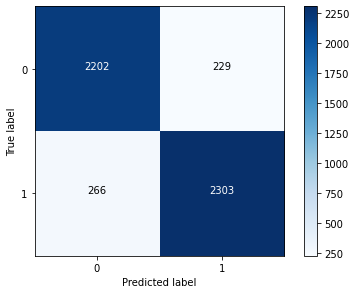

In [78]:
print("\nConfusion matrix")
conf_matrix = confusion_matrix(y_pred.round(), y_valid)
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
tick_marks = np.arange(2)   
classes = ["0","1"]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
thresho = conf_matrix.max() / 2.
# The below for loop helps to add numbers in the boxes
for k, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, k, conf_matrix[k, j], horizontalalignment="center", color="white" if conf_matrix[k, j] > thresho else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

ROC AUC Score : 0.9008890416605857


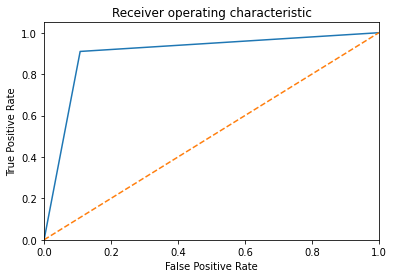

In [79]:
# Below is the ROC curve
import sklearn.metrics as m
print("ROC AUC Score : {}".format(m.roc_auc_score(y_valid, y_pred.round())))

fpr, tpr, threshold = m.roc_curve(y_valid, y_pred.round())
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()